In [56]:
# Import Liblary yang akan digunakan
import os
import Augmentor
import zipfile
import random
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
#Unzip data set 
local_zip = 'Discoloration.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Dataset/')
zip_ref.close()

local_zip2 = 'Periodontal.zip'
zip_ref2    = zipfile.ZipFile(local_zip2, 'r')
zip_ref2.extractall('Dataset/') 
zip_ref2.close()

In [73]:
print(len(os.listdir('Dataset/Discoloration')))
print(len(os.listdir('Dataset/Periodontal')))
print(len(os.listdir('Dataset/Healthy')))

1000
1000
1000


In [105]:
def AugmentData(source_dir, count):
    source_dir = source_dir
    output_dir = "."
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.001, max_left_rotation=0.001, max_right_rotation=0.001)
    #p.zoom_random(probability=0.5, percentage_area=0.9)
    #p.crop_random(probability=0.6, percentage_area=0.9)
    #p.resize(probability=1.0, width=64, height=64)
    p.sample(count)

In [106]:
AugmentData("Dataset/Discoloration/", 1000)
AugmentData("Dataset/Periodontal/", 1000)
AugmentData("Dataset/Healthy/", 1000)

Initialised with 40 image(s) found.
Output directory set to Dataset/Discoloration/..

Processing <PIL.Image.Image image mode=RGB size=436x336 at 0x207CF6C5C70>: 100%|█| 1000/1000 [00:03<00:00, 313.43 Sampl


Initialised with 17 image(s) found.
Output directory set to Dataset/Periodontal/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x675 at 0x207CF72A2E0>: 100%|█| 1000/1000 [00:01<


Initialised with 90 image(s) found.
Output directory set to Dataset/Healthy/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x328 at 0x2073F350610>: 100%|█| 1000/1000 [00:02<0


In [108]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Discoloration_SOURCE_DIR = "Dataset/Discoloration/"
Periodontal_SOURCE_DIR = "Dataset/Periodontal/"
Healthy_SOURCE_DIR = "Dataset/Healthy/"

TRAINING_Discoloration_DIR = "Dataset_Real/training/Dental Discoloration/"
TRAINING_Periodontal_DIR = "Dataset_Real/training/Periodontal/"
TRAINING_Healthy_DIR = "Dataset_Real/training/Healthy/"

TESTING_Discoloration_DIR = "Dataset_Real/testing/Dental Discoloration/"
TESTING_Periodontal_DIR = "Dataset_Real/testing/Periodontal/"
TESTING_Healthy_DIR = "Dataset_Real/testing/Healthy/"

split_size = .8
split_data(Discoloration_SOURCE_DIR, TRAINING_Discoloration_DIR, TESTING_Discoloration_DIR, split_size)
split_data(Periodontal_SOURCE_DIR, TRAINING_Periodontal_DIR, TESTING_Periodontal_DIR, split_size)
split_data(Healthy_SOURCE_DIR, TRAINING_Healthy_DIR, TESTING_Healthy_DIR, split_size)

In [2]:
TRAINING_DIR = "Dataset_Real/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = "Dataset_Real/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [86]:
dim = (150, 150)
channel = (3, )
input_shape = dim + channel

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, input_shape)
validation_data = tf_data_generator(validation_generator, input_shape)

In [94]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.2)
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 128)     

In [95]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [96]:
history = model.fit(train_data,
                    steps_per_epoch=40,
                    epochs=20,
                    validation_data=validation_data,
                    validation_steps=20,
                    shuffle=True,
                    verbose=2)

Epoch 1/20
40/40 - 9s - loss: 1.0905 - accuracy: 0.3638 - val_loss: 1.0632 - val_accuracy: 0.4900 - 9s/epoch - 216ms/step
Epoch 2/20
40/40 - 6s - loss: 1.0418 - accuracy: 0.4600 - val_loss: 0.9684 - val_accuracy: 0.6450 - 6s/epoch - 158ms/step
Epoch 3/20
40/40 - 6s - loss: 0.9298 - accuracy: 0.5512 - val_loss: 0.8983 - val_accuracy: 0.5200 - 6s/epoch - 156ms/step
Epoch 4/20
40/40 - 6s - loss: 0.8106 - accuracy: 0.6250 - val_loss: 0.7938 - val_accuracy: 0.6450 - 6s/epoch - 154ms/step
Epoch 5/20
40/40 - 6s - loss: 0.7648 - accuracy: 0.6675 - val_loss: 0.6363 - val_accuracy: 0.7700 - 6s/epoch - 152ms/step
Epoch 6/20
40/40 - 6s - loss: 0.6106 - accuracy: 0.7400 - val_loss: 0.7042 - val_accuracy: 0.6850 - 6s/epoch - 150ms/step
Epoch 7/20
40/40 - 6s - loss: 0.5599 - accuracy: 0.7750 - val_loss: 0.5453 - val_accuracy: 0.7600 - 6s/epoch - 151ms/step
Epoch 8/20
40/40 - 6s - loss: 0.5312 - accuracy: 0.7862 - val_loss: 0.4960 - val_accuracy: 0.8200 - 6s/epoch - 153ms/step
Epoch 9/20
40/40 - 6s - 

In [90]:
model.evaluate(validation_generator)

60/60 [==============================] - 5s 72ms/step - loss: 0.2728 - accuracy: 0.8850


[0.2727687954902649, 0.8849999904632568]

In [91]:
#classes 
class_names =  ["Discloration", "Healthy", "Periodontal"]
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

Discloration   0
Healthy   1
Periodontal   2


In [24]:
import numpy as np
from keras.preprocessing import image

path = "4.jpeg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 1. 0.]]


[[0. 0. 1.]]
[2]
Periodontal


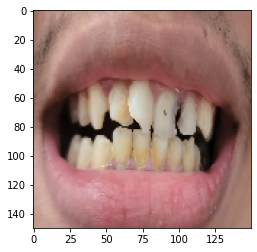

In [25]:
import matplotlib.pyplot as plt

image_path = "5.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
print(prediction)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)

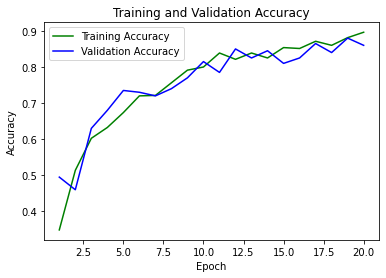

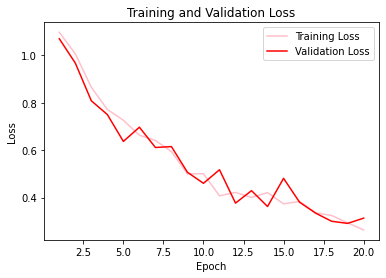

In [16]:
#plotting training values

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
model.save('model.h5')

In [55]:
export_dir = 'saved_model/1/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [38]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [42]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

39310376

In [45]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [46]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [52]:
image_path = "1.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
rflite_results = interpreter.get_tensor(output_details[0]['index'])

In [53]:
print(rflite_results)

[[1. 0. 0.]]


In [200]:
print(input_details)
print(output_details)

[{'name': 'serving_default_conv2d_15_input:0', 'index': 0, 'shape': array([  1, 150, 150,   3]), 'shape_signature': array([ -1, 150, 150,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 24, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
class_names

[0.25552574 0.742077   0.00239725]
Prediksi : Healthy
Persentase Keyakinan : 74.21 %

Prediksi : Discloration
Persentase Keyakinan : 25.55 %
Prediksi : Healthy
Persentase Keyakinan : 74.21 %
Prediksi : Periodontal
Persentase Keyakinan : 0.24 %


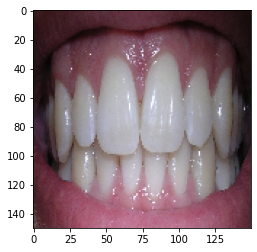

In [199]:
path = "2.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
prediction = np.argmax(classes,axis=1)
print(classes[0])

print("Prediksi : {}".format(class_names[prediction[0]]))
print("Persentase Keyakinan : {:.2f} %\n".format(np.max(classes) * 100))

for i in range(len(class_names)):
    print("Prediksi : {}".format(class_names[i]))
    print("Persentase Keyakinan : {:.2f} %".format(classes[0][i] * 100))  
          
plt.imshow(img)

[[1. 0. 0.]]
[0]
Discloration


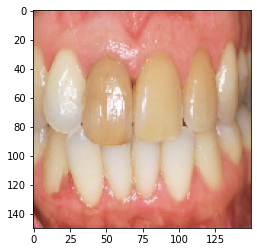

In [156]:
import matplotlib.pyplot as plt

image_path = "8.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
print(prediction)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)

In [144]:
import numpy as np
from keras.preprocessing import image

path = "4.jpeg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 1. 0.]]
